In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ml-fall2019-android-malware/readme.pdf
/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.train
/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.eval.anon
/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/eval.id
/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.test
/kaggle/input/ml-fall2019-android-malware/data/data/sample-solutions/sample.solution.all.positive.csv
/kaggle/input/ml-fall2019-android-malware/data/data/sample-solutions/sample.solution.half-neg.csv


In [2]:
## convert libsvm to sparse matrix
from scipy.sparse import csr_matrix
import numpy as np
import statistics
import glob
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing

In [3]:
from scipy.sparse import csr_matrix
import numpy as np
def read_libsvm(fname, num_features=0):
    '''
        Reads a libsvm formatted data and outputs the training set (sparse matrix)[1], 
        the label set and the number of features. The number of features
        can either be provided as a parameter or inferred from the data.

		Example usage:
		
		X_train, y_train, num_features = read_libsvm('data_train')
		X_test, y_test, _ = read_libsvm('data_test', num_features)

		[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
	'''
    data = []
    y = []
    row_ind = []
    col_ind = []
    with open(fname) as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            elements = line.split()
            y.append(int(elements[0]))
            for el in elements[1:]:
                row_ind.append(i)
                c, v = el.split(":")
                col_ind.append(int(c))
                data.append(float(v))
    if num_features == 0:
        num_features = max(col_ind) + 1
    X = csr_matrix((data, (row_ind, col_ind)), shape=(len(y), num_features+1))

    return X, np.array(y), num_features

In [4]:
X_train, y_train, num_features = read_libsvm('/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.train',0)
X_test, y_test, _ = read_libsvm('/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.test', 0)
X_eval, y_eval, _ = read_libsvm('/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.eval.anon', 0)
X_train_df = pd.DataFrame(X_train.toarray())
X_test_df= pd.DataFrame(X_test.toarray())
X_eval_df = pd.DataFrame(X_eval.toarray())

In [5]:
def convert(col):
    #print(col)
    median = col.median()
    #print("m",median)
    col[col<median]=0
    col[col>median]=1
    return col

X_train_df = X_train_df.apply(convert,axis=0)
X_train_to = X_train_df.copy()
X_train_df['label'] = y_train

########    
X_test_df = X_test_df.apply(convert,axis=0)
X_eval_df = X_eval_df.apply(convert,axis=0)

In [6]:
def check_labels_same_data(data):
    
    label = data[:, -1]
    uniqueValues, _ = np.unique(label, return_counts=True)
    if len(uniqueValues) == 1:
        return True
    else:
        return False

In [7]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [8]:
def split_points(data):
    
    potential_splits = {}
    _, columns = data.shape
    for index in range(columns - 1):       
        values = data[:, index]
        uniqueValues, _ = np.unique(values, return_counts=True)
        potential_splits[index] = uniqueValues
    
    return potential_splits

In [9]:
def data_divide_2(data, split_column, split_value):  
    column_values = data[:, split_column]
    less_data = data[column_values == split_value]
    more_data = data[column_values != split_value]

    return less_data, more_data

In [10]:

def expected_entropy(data):
    
    label = data[:, -1]
    _, num = np.unique(label, return_counts=True)

    prob = num / num.sum()
    entropy = sum(prob * -np.log2(prob))
     
    return entropy

In [11]:
def calculate_entropy(less_data, more_data):
    
    n = len(less_data) + len(more_data)
    p_data_below = len(less_data) / n
    p_data_above = len(more_data) / n

    overall_entropy =  (p_data_below * expected_entropy(less_data) 
                      + p_data_above * expected_entropy(more_data))
    
    return overall_entropy

In [12]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = data_divide_2(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [13]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
     
    if (check_labels_same_data(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    else:

        counter += 1

        potential_splits = split_points(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = data_divide_2(data, split_column, split_value)

        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification

        feature_name = COLUMN_HEADERS[split_column]

        question = "{} = {}".format(feature_name, split_value)

        sub_tree = {question: []}

        true = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        false = decision_tree_algorithm(data_above, counter, min_samples, max_depth)

        if true == false:
            sub_tree = true
        else:
            sub_tree[question].append(true)
            sub_tree[question].append(false)

        return sub_tree

In [14]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")
    if comparison_operator == "=":
        if example[int(feature_name)] == float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
     
    if not isinstance(answer, dict):
        return answer
    else:
    
        residual_tree = answer
        return classify_example(example, residual_tree)

In [15]:

def calculate_accuracy(df,tree):
    predict_list= df.apply(classify_example, args=(tree,), axis=1)
    return predict_list

In [16]:
import collections, numpy
import sklearn.metrics as metrics
acc_list=[]
random_df = pd.DataFrame()
for d in [25]:
    for k in [3,25,50,100]:
        print("k trees=",k,"**********************")
        for i in range(0,k):
            print("for each tree in ",i)
            new_train_df = pd.DataFrame()
            #choose random indxeds
            random_indexes=[random.randint(0,X_train_df.shape[1]-2) for i in range(100)]
            for index in random_indexes:
                new_train_df[index] =X_train_df[index] 
                
            new_train_df['label'] = X_train_df['label']
            #print(new_train_df.head())
              
            tree = decision_tree_algorithm(new_train_df,max_depth = d)    
            #print("TREEE",tree)
            predict_list = calculate_accuracy(X_test_df, tree)
            y_predict = predict_list.tolist()
            random_df[i] = y_predict
        mode_df = random_df.mode(axis=1)
        y_predict = mode_df[0]
        precision=metrics.precision_score(y_test, y_predict)
        recall=metrics.recall_score(y_test, y_predict)
        print(collections.Counter(predict_list))
        print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
        acc_list.append(metrics.accuracy_score(y_test, y_predict))
        print("Precision:",metrics.precision_score(y_test, y_predict))
        print("Recall:",metrics.recall_score(y_test, y_predict))


k trees= 3 **********************
for each tree in  0
for each tree in  1
for each tree in  2
Counter({0.0: 1580, 1.0: 951})
Accuracy: 0.847096009482418
Precision: 0.7422680412371134
Recall: 0.8401400233372228
k trees= 25 **********************
for each tree in  0
for each tree in  1
for each tree in  2
for each tree in  3
for each tree in  4
for each tree in  5
for each tree in  6
for each tree in  7
for each tree in  8
for each tree in  9
for each tree in  10
for each tree in  11
for each tree in  12
for each tree in  13
for each tree in  14
for each tree in  15
for each tree in  16
for each tree in  17
for each tree in  18
for each tree in  19
for each tree in  20
for each tree in  21
for each tree in  22
for each tree in  23
for each tree in  24
Counter({0.0: 1508, 1.0: 1023})
Accuracy: 0.8743579612801264
Precision: 0.7839831401475237
Recall: 0.868144690781797
k trees= 50 **********************
for each tree in  0
for each tree in  1
for each tree in  2
for each tree in  3
for each

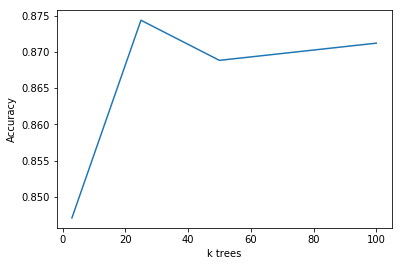

In [17]:
import matplotlib.pyplot as plt
plt.plot([3, 25, 50, 100],acc_list)
plt.ylabel('Accuracy')
plt.xlabel('k trees')
plt.show()

EVAL DATA 

In [18]:
import collections, numpy
import sklearn.metrics as metrics

random_df = pd.DataFrame()
for d in [25]:
    for k in [50]:
        print("k trees=",k,"**********************")
        for i in range(0,k):
            predict_list = calculate_accuracy(X_eval_df, tree)
            y_predict = predict_list.tolist()
            random_df[i] = y_predict
            
        mode_df = random_df.mode(axis=1)
        y_predict = mode_df[0]


k trees= 50 **********************


In [19]:
y_predict_list = y_predict.values

In [20]:
y_predict_list =np.where(y_predict_list==1.0,1,0)
y_predict_list

array([1, 0, 1, ..., 0, 0, 0])

CSV DOWNLOAD CODE

In [21]:
eval_id_list=[]
with open("/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/eval.id") as f:
    lines = f.readlines()
    
for ele in lines:
    ele=ele.rstrip("\n")
    eval_id_list.append(ele)  

In [22]:
list_of_tuples = list(zip(eval_id_list, y_predict_list))  
    
# Assign data to tuples.  
list_of_tuples   
  
  
# Converting lists of tuples into  
# pandas Dataframe.  
df_new = pd.DataFrame(list_of_tuples, columns = ['example_id', 'label'])  
     
# Print data.  
df_new

,example_id,label
0,2591,1
1,10174,0
2,4764,1
3,5429,1
4,11235,0
...,...,...
2527,1681,0
2528,9320,0
2529,2301,0
2530,1175,0


In [23]:
df_new.to_csv(r'df_new.csv')
from IPython.display import FileLink
FileLink(r'df_new.csv')

/kaggle/working/df_new.csv